In [1]:
pip install pennylane

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.1/56.1 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 27.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.8/930.8 kB 39.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 53.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 54.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 68.2 MB/s eta 0:00:00


In [2]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

import pennylane as qml
from sklearn.preprocessing import MinMaxScaler

/usr/local/lib/python3.11/dist-packages/pennylane/capture/capture_operators.py:33: RuntimeWarning: PennyLane is not yet compatible with JAX versions > 0.4.28. You have version 0.5.2 installed. Please downgrade JAX to <=0.4.28 to avoid runtime errors.
  warnings.warn(


In [3]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
set_seed(42)

In [4]:
class SimpleQLSTMCell(nn.Module):
    def __init__(self, input_size, n_qubits, n_layers=1):
        super().__init__()
        self.input_size = input_size
        self.n_qubits = n_qubits
        self.n_layers = n_layers

        dev = qml.device("lightning.qubit", wires=n_qubits)

        @qml.qnode(dev, interface="torch", diff_method="parameter-shift")
        def circuit(inputs, weights):
            for i in range(n_qubits):
                qml.Hadamard(wires=i)
                qml.RY(inputs[i], wires=i)
            qml.templates.StronglyEntanglingLayers(weights, wires=range(n_qubits))
            return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

        weight_shapes = {"weights": (n_layers, n_qubits, 3)}
        self.qlayer = qml.qnn.TorchLayer(circuit, weight_shapes)

        # Now classical layers come after the quantum layer
        self.linear_forget = nn.Linear(n_qubits + n_qubits, n_qubits)
        self.linear_input_gate = nn.Linear(n_qubits + n_qubits, n_qubits)

    def forward(self, x, hidden):
        h_prev, c_prev = hidden

        # Quantum layer processes the raw input first
        batch_size = x.size(0)
        q_outputs = [self.qlayer(x[i]) for i in range(batch_size)]
        q_output = torch.stack(q_outputs)

        # Then we combine quantum output with h_prev
        combined = torch.cat((q_output, h_prev), dim=1)

        f_t = torch.sigmoid(self.linear_forget(combined))
        i_t = torch.sigmoid(self.linear_input_gate(combined))
        h_next = torch.tanh(q_output)
        c_next = f_t * c_prev + i_t * h_next
        return h_next, c_next

In [5]:
class SimpleQRegressionLSTM(nn.Module):
    def __init__(self, num_features, n_qubits=4, n_layers=1):
        super().__init__()
        self.num_features = num_features
        self.n_qubits = n_qubits
        self.qlstm = SimpleQLSTMCell(num_features, n_qubits, n_layers)
        self.regressor = nn.Linear(n_qubits, 1)

    def forward(self, x):
        batch_size, seq_len, _ = x.shape
        h = torch.zeros(batch_size, self.n_qubits, device=x.device)
        c = torch.zeros(batch_size, self.n_qubits, device=x.device)

        for t in range(seq_len):
            h, c = self.qlstm(x[:, t, :], (h, c))

        output = self.regressor(h).squeeze()
        return output

In [6]:
df = pd.read_excel("/content/FINALDATA.xlsx")

In [7]:
target_column = 'US TBill 10Y Yield(%)'
df['Yield_lag1'] = df[target_column].shift(1)
df['Yield_lag3'] = df[target_column].shift(3)
df['Yield_lag6'] = df[target_column].shift(6)
df['Yield_ma3'] = df[target_column].rolling(window=3).mean()
df['Yield_ma6'] = df[target_column].rolling(window=6).mean()
df['Yield_ma12'] = df[target_column].rolling(window=12).mean()

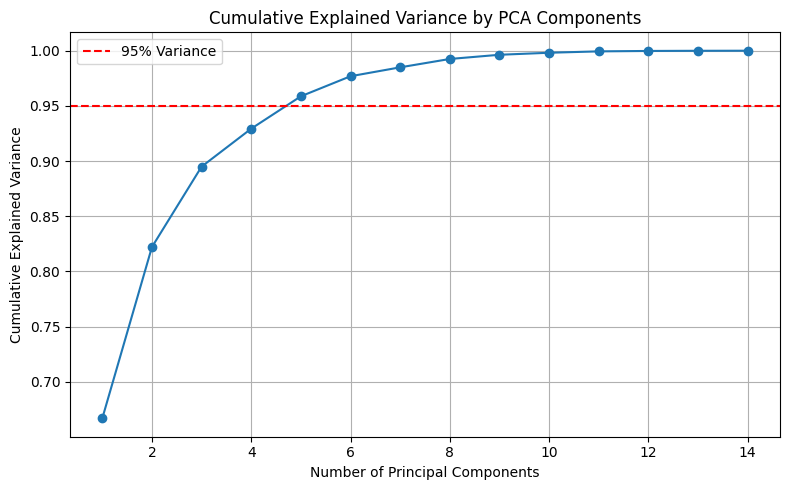

Number of components to retain 95% variance: 5


In [8]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Drop NaNs and reset index
df = df.dropna().reset_index(drop=True)
feature_columns = df.drop(columns=['Date', target_column]).columns

# Define features and target
features = df[feature_columns]
target = df[[target_column]]  # DataFrame format for scaler compatibility

# Split index for training data
split_index_raw = int(len(features) * 0.8)

# ----------- PCA Explained Variance Step ----------------
# Scale features for PCA (StandardScaler preferred for PCA)
scaler_pre_pca = StandardScaler()
features_scaled_for_pca = scaler_pre_pca.fit_transform(features.iloc[:split_index_raw])

# Fit PCA without limiting components to get explained variance
pca_full = PCA()
pca_full.fit(features_scaled_for_pca)
cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)

# Plot cumulative variance to decide component count
plt.figure(figsize=(8, 5))
plt.plot(np.arange(1, len(cumulative_variance)+1), cumulative_variance, marker='o')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Variance')
plt.title('Cumulative Explained Variance by PCA Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Get number of components that retain 95% variance
n_components_opt = np.argmax(cumulative_variance >= 0.95) + 1
print(f"Number of components to retain 95% variance: {n_components_opt}")

# -------------- PCA and Scaling ---------------------
# Fit PCA with optimal number of components
pca = PCA(n_components=n_components_opt)
pca.fit(features_scaled_for_pca)

# Apply same StandardScaler to full feature set
features_scaled_full = scaler_pre_pca.transform(features)

# Apply PCA to entire dataset
features_pca = pca.transform(features_scaled_full)

# Scale PCA features using MinMaxScaler on training data
feature_scaler = MinMaxScaler()
feature_scaler.fit(features_pca[:split_index_raw])
features_scaled = feature_scaler.transform(features_pca)

# Scale target variable using MinMaxScaler on training target
target_scaler = MinMaxScaler()
target_scaler.fit(target.iloc[:split_index_raw])
target_scaled = target_scaler.transform(target)

# Combine scaled PCA features and target
pca_columns = [f'PC{i+1}' for i in range(n_components_opt)]
df_features = pd.DataFrame(features_scaled, columns=pca_columns)
df_target = pd.DataFrame(target_scaled, columns=[target_column])
df_scaled = pd.concat([df_features, df_target], axis=1)

# ---------- Sequence Creation -----------------
def create_sequences(input_data, target_data, window):
    X, y = [], []
    for i in range(window, len(input_data)):
        X.append(input_data[i-window:i])
        y.append(target_data[i])
    return np.array(X), np.array(y)

# Prepare input and target arrays
input_data = df_scaled[pca_columns].values
target_data = df_scaled[target_column].values

# Create sequences
history_window = 48
X_all, y_all = create_sequences(input_data, target_data, history_window)

# Final train-test split
split_index = int(len(X_all) * 0.8)
X_train, X_test = X_all[:split_index], X_all[split_index:]
y_train, y_test = y_all[:split_index], y_all[split_index:]

In [9]:
X_train

array([[[0.89046959, 0.        , 0.54749967, 0.2007572 , 0.37389028],
        [0.87648923, 0.02595404, 0.65540585, 0.20351866, 0.43404603],
        [0.89980239, 0.03537531, 0.55560456, 0.13707475, 0.34284808],
        ...,
        [0.83887956, 0.47072207, 0.60957606, 0.27500197, 0.22783042],
        [0.81511199, 0.48430693, 0.76816535, 0.32372594, 0.26473268],
        [0.80432207, 0.51783806, 0.68716524, 0.29483482, 0.24411167]],

       [[0.87648923, 0.02595404, 0.65540585, 0.20351866, 0.43404603],
        [0.89980239, 0.03537531, 0.55560456, 0.13707475, 0.34284808],
        [0.89249296, 0.03592218, 0.7323715 , 0.15543776, 0.34019803],
        ...,
        [0.81511199, 0.48430693, 0.76816535, 0.32372594, 0.26473268],
        [0.80432207, 0.51783806, 0.68716524, 0.29483482, 0.24411167],
        [0.79243394, 0.51257893, 0.73902826, 0.2995137 , 0.21625407]],

       [[0.89980239, 0.03537531, 0.55560456, 0.13707475, 0.34284808],
        [0.89249296, 0.03592218, 0.7323715 , 0.15543776, 0.3

In [10]:
y_train

array([0.7198159 , 0.75530382, 0.80845821, 0.83666259, 0.81481195,
       0.82767438, 0.85076477, 0.81357219, 0.75716345, 0.71144757,
       0.769406  , 0.78118365, 0.79017186, 0.84456601, 0.81589673,
       0.80675355, 0.78211347, 0.70633359, 0.75716345, 0.72059074,
       0.67843915, 0.68510282, 0.6646469 , 0.62791923, 0.64605061,
       0.65100962, 0.6536441 , 0.63520278, 0.61877605, 0.62621457,
       0.54594058, 0.45977777, 0.48844705, 0.50533868, 0.49511073,
       0.49557563, 0.59413597, 0.58716236, 0.60358908, 0.64605061,
       0.67053573, 0.68959693, 0.69997985, 0.68556773, 0.70834818,
       0.73422802, 0.77312526, 0.80768337, 0.76801128, 0.7052488 ,
       0.73748237, 0.74678052, 0.70943297, 0.70943297, 0.66201243,
       0.67394505, 0.66604162, 0.62218537, 0.56701638, 0.56732632,
       0.53354306, 0.53679741, 0.60203939, 0.60870306, 0.61350711,
       0.55802817, 0.52362504, 0.48581258, 0.43064359, 0.51122751,
       0.55756327, 0.55477382, 0.53059865, 0.6110276 , 0.56278

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)

train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=8, shuffle=False)

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from itertools import product

# Example: You might have already defined this
# from your_model_file import SimpleQRegressionLSTM

n_epochs = 100
patience = 3
delta = 1e-3

# Define hyperparameter grid
n_qubits_list = [4]
learning_rates = [0.01]
n_layers_list = [3]

best_overall_loss = float('inf')
best_hparams = {}
best_model_state = None

for n_qubits, lr, n_layers in product(n_qubits_list, learning_rates, n_layers_list):
    print(f"\nTraining with n_qubits={n_qubits}, lr={lr}, n_layers={n_layers}")

    model = SimpleQRegressionLSTM(num_features=X_all.shape[2], n_qubits=n_qubits, n_layers=n_layers).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    best_loss = float('inf')
    epochs_no_improve = 0
    local_best_state = None

    for epoch in range(n_epochs):
        model.train()
        epoch_loss = 0.0

        for xb, yb in train_loader:
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(train_loader)
        print(f"Epoch {epoch+1}, Loss: {avg_loss:.6f}")

        if avg_loss < best_loss - delta:
            best_loss = avg_loss
            local_best_state = model.state_dict()
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print(f"Early stopping at epoch {epoch+1}, best loss: {best_loss:.6f}")
            break

    # Check if this config is the best so far
    if best_loss < best_overall_loss:
        best_overall_loss = best_loss
        best_model_state = local_best_state
        best_hparams = {
            'n_qubits': n_qubits,
            'learning_rate': lr,
            'n_layers': n_layers
        }

# Load best model state
if best_model_state is not None:
    model = SimpleQRegressionLSTM(num_features=X_all.shape[2],
                                  n_qubits=best_hparams['n_qubits'],
                                  n_layers=best_hparams['n_layers']).to(device)
    model.load_state_dict(best_model_state)
    print(f"\nBest model restored with hyperparameters: {best_hparams}")
    print(f"Best training loss: {best_overall_loss:.6f}")


Training with n_qubits=4, lr=0.01, n_layers=3
Epoch 1, Loss: 0.197289
Epoch 2, Loss: 0.055423
Epoch 3, Loss: 0.052450
Epoch 4, Loss: 0.044537
Epoch 5, Loss: 0.036782
Epoch 6, Loss: 0.027064
Epoch 7, Loss: 0.016857
Epoch 8, Loss: 0.009527
Epoch 9, Loss: 0.006020
Epoch 10, Loss: 0.004755
Epoch 11, Loss: 0.004315
Epoch 12, Loss: 0.004166
Epoch 13, Loss: 0.004141
Early stopping at epoch 13, best loss: 0.004755

Best model restored with hyperparameters: {'n_qubits': 4, 'learning_rate': 0.01, 'n_layers': 3}
Best training loss: 0.004755


In [13]:
model.eval()
with torch.no_grad():
    preds = model(X_test_tensor).cpu().numpy()
    y_true = y_test_tensor.cpu().numpy()

In [14]:
# Inverse transform predictions and actuals
y_pred_inverse = target_scaler.inverse_transform(preds.reshape(-1, 1))
y_test_inverse = target_scaler.inverse_transform(y_test.reshape(-1, 1))

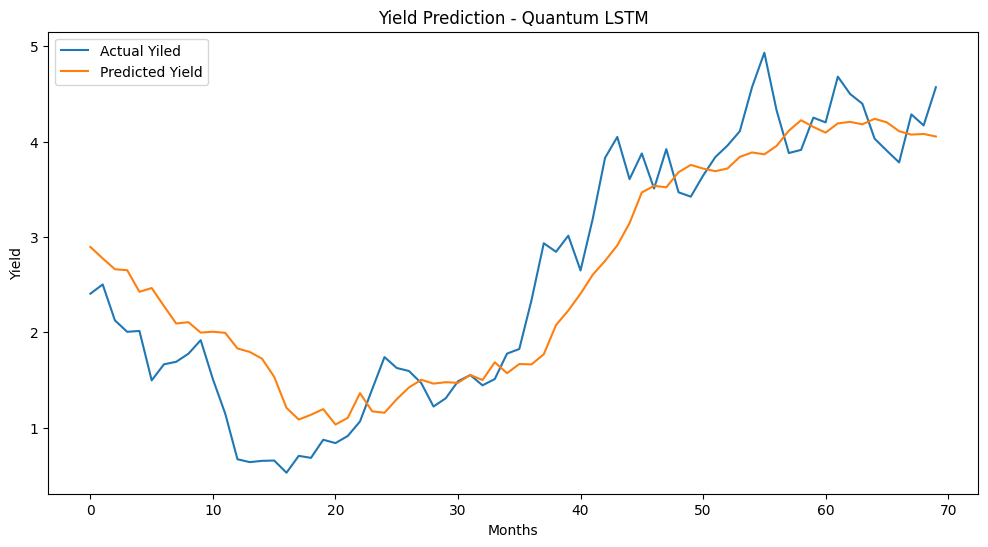

In [15]:
plt.figure(figsize=(12, 6))
plt.plot(y_test_inverse, label='Actual Yiled')
plt.plot(y_pred_inverse, label='Predicted Yield')
plt.title("Yield Prediction - Quantum LSTM")
plt.xlabel("Months")
plt.ylabel("Yield")
plt.legend()
plt.show()

In [16]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

mae = mean_absolute_error(y_pred_inverse, y_test_inverse)
mse = mean_squared_error(y_pred_inverse, y_test_inverse)
rmse = np.sqrt(mse)
r2 = r2_score(y_pred_inverse, y_test_inverse)

print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (R²): {r2:.4f}")

Mean Absolute Error (MAE): 0.4253
Mean Squared Error (MSE): 0.2816
Root Mean Squared Error (RMSE): 0.5307
R-squared (R²): 0.7701


In [17]:
model.eval()
with torch.no_grad():
    train_preds = model(X_train_tensor).cpu().numpy()
    train_true = y_train_tensor.cpu().numpy()

In [18]:
# Inverse transform predictions and actuals
train_preds_inverse = target_scaler.inverse_transform(train_preds.reshape(-1, 1))
train_true_inverse = target_scaler.inverse_transform(train_true.reshape(-1, 1))

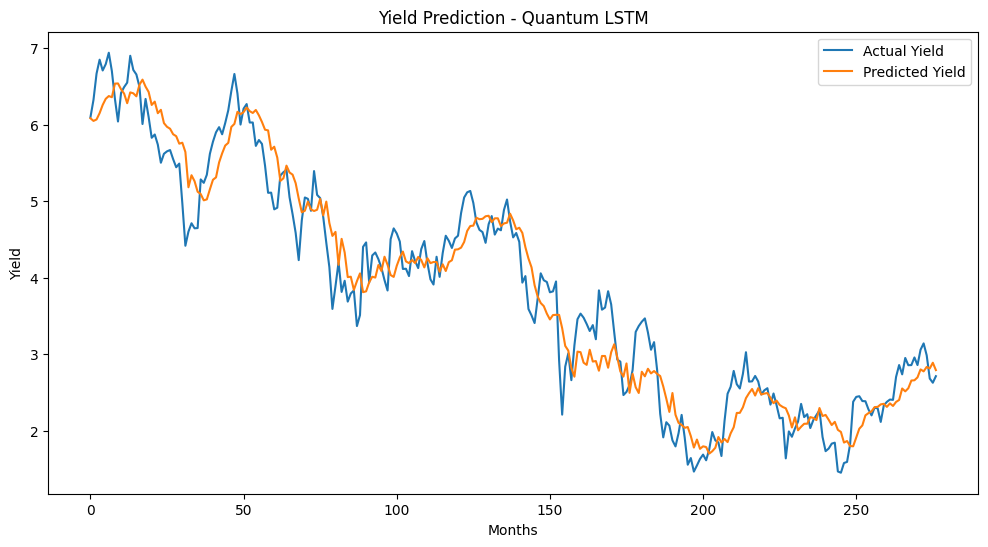

In [19]:
plt.figure(figsize=(12, 6))
plt.plot(train_true_inverse, label='Actual Yield')
plt.plot(train_preds_inverse, label='Predicted Yield')
plt.title("Yield Prediction - Quantum LSTM")
plt.xlabel("Months")
plt.ylabel("Yield")
plt.legend()
plt.show()

In [20]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

mae = mean_absolute_error(train_preds_inverse, train_true_inverse)
mse = mean_squared_error(train_preds_inverse, train_true_inverse)
rmse = np.sqrt(mse)
r2 = r2_score(train_preds_inverse, train_true_inverse)

print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (R²): {r2:.4f}")

Mean Absolute Error (MAE): 0.3200
Mean Squared Error (MSE): 0.1569
Root Mean Squared Error (RMSE): 0.3961
R-squared (R²): 0.9291
